##Samer Baslan
##CMPE-258: Deep Learning
##Spring 2021, Vijay Eranti
##HW6, Part B: CNN Based Image Classifier using PyTorch and Fashion MNIST data


Resource: PyTorch Tutorial Basic by Michael Li https://colab.research.google.com/drive/1YWzAjpAnLI23irBQtLvDTYT1A94uCloM

##Imports

In [1]:
!pip install scikit-plot

In [2]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import scikitplot as skplt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import torchvision
import torchvision.transforms as transforms

import time
import pandas as pd
import json
from IPython.display import clear_output

from collections  import OrderedDict
from collections import namedtuple
from itertools import product


torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)

##Load Data

In [3]:
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

In [4]:
# Build the neural network on top of nn.Module
class Network(nn.Module):
  def __init__(self):
    super().__init__()

    # Define Layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

    self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=60)
    self.out = nn.Linear(in_features=60, out_features=10)


  def forward(self, t):
    # conv 1
    t = self.conv1(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    # conv 2
    t = self.conv2(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    # fc1
    t = t.reshape(-1, 12*4*4)
    t = self.fc1(t)
    t = F.relu(t)

    # fc2
    t = self.fc2(t)
    t = F.relu(t)

    # output
    t = self.out(t)
    # No need for softmax as we will use cross entropy for activation.

    return t

In [5]:
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

In [6]:
# Read in the hyper-parameters and return a Run namedtuple containing all the combinations of hyper-parameters

class RunBuilder():
  @staticmethod
  def get_runs(params):

    Run = namedtuple('Run', params.keys())

    runs = []
    for v in product(*params.values()):
      runs.append(Run(*v))
    
    return runs

In [7]:
class RunManager():
  def __init__(self):

    # track every epoch count, loss, accuracy, time
    self.epoch_count = 0
    self.epoch_loss = 0
    self.epoch_num_correct = 0
    self.epoch_start_time = None

    # track every run count, run data, hyper-params used, time
    self.run_params = None
    self.run_count = 0
    self.run_data = []
    self.run_start_time = None

    # record model, loader and TensorBoard 
    self.network = None
    self.loader = None
    self.tb = None

  # record the count, hyper-param, model, loader of each run
  # record sample images and network graph to TensorBoard  
  def begin_run(self, run, network, loader):

    self.run_start_time = time.time()

    self.run_params = run
    self.run_count += 1

    self.network = network
    self.loader = loader
    self.tb = SummaryWriter(comment=f'-{run}')

    images, labels = next(iter(self.loader))
    grid = torchvision.utils.make_grid(images)

    self.tb.add_image('images', grid)
    self.tb.add_graph(self.network, images)

  # when run ends, close TensorBoard, zero epoch count
  def end_run(self):
    self.tb.close()
    self.epoch_count = 0

  # zero epoch count, loss, accuracy, 
  def begin_epoch(self):
    self.epoch_start_time = time.time()

    self.epoch_count += 1
    self.epoch_loss = 0
    self.epoch_num_correct = 0


  def end_epoch(self):
    # calculate epoch duration and run duration
    epoch_duration = time.time() - self.epoch_start_time
    run_duration = time.time() - self.run_start_time

    # record epoch loss and accuracy
    loss = self.epoch_loss / len(self.loader.dataset)
    accuracy = self.epoch_num_correct / len(self.loader.dataset)

    # Record epoch loss and accuracy to TensorBoard 
    self.tb.add_scalar('Loss', loss, self.epoch_count)
    self.tb.add_scalar('Accuracy', accuracy, self.epoch_count)

    # Record params to TensorBoard
    for name, param in self.network.named_parameters():
      self.tb.add_histogram(name, param, self.epoch_count)
      self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)
    
    # Write into 'results' (OrderedDict) for all run related data
    results = OrderedDict()
    results["run"] = self.run_count
    results["epoch"] = self.epoch_count
    results["loss"] = loss
    results["accuracy"] = accuracy
    results["epoch duration"] = epoch_duration
    results["run duration"] = run_duration

    # Record hyper-params into 'results'
    for k,v in self.run_params._asdict().items(): results[k] = v
    self.run_data.append(results)
    df = pd.DataFrame.from_dict(self.run_data, orient = 'columns')

    # display epoch information and show progress
    clear_output(wait = True)
    display(df)

  # accumulate loss of batch into entire epoch loss
  def track_loss(self, loss):
    # multiply batch size so variety of batch sizes can be compared
    self.epoch_loss += loss.item() * self.loader.batch_size

  # accumulate number of corrects of batch into entire epoch num_correct
  def track_num_correct(self, preds, labels):
    self.epoch_num_correct += self._get_num_correct(preds, labels)

  @torch.no_grad()
  def _get_num_correct(self, preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [8]:
# put all hyper params into a OrderedDict, easily expandable
params = OrderedDict(
    lr = [.01, .001],
    batch_size = [100, 1000],
    shuffle = [False]
)
epochs = 5

In [9]:
m = RunManager()

# get all runs from params using RunBuilder class
for run in RunBuilder.get_runs(params):

    # if params changes, following line of code should reflect the changes too
    network = Network()
    loader = torch.utils.data.DataLoader(train_set, batch_size = run.batch_size)
    optimizer = optim.Adam(network.parameters(), lr = run.lr)

    m.begin_run(run, network, loader)
    for epoch in range(epochs):
      
      m.begin_epoch()
      for batch in loader:
        
        images = batch[0]
        labels = batch[1]
        preds = network(images)
        loss = F.cross_entropy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        m.track_loss(loss)
        m.track_num_correct(preds, labels)

      m.end_epoch()
    m.end_run()


,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,shuffle
0,1,1,0.581363,0.779433,16.631452,18.517974,0.010,100,False
1,1,2,0.409849,0.848767,16.583174,35.221905,0.010,100,False
2,1,3,0.375367,0.860383,16.704577,52.064644,0.010,100,False
3,1,4,0.361097,0.865217,16.654043,68.874512,0.010,100,False
4,1,5,0.349815,0.870167,16.630364,85.661284,0.010,100,False
5,2,1,1.045336,0.595683,14.879819,15.839304,0.010,1000,False
6,2,2,0.558461,0.782533,14.681833,30.653673,0.010,1000,False
7,2,3,0.463485,0.828333,14.761484,45.572459,0.010,1000,False
8,2,4,0.408093,0.850917,14.845619,60.584049,0.010,1000,False
9,2,5,0.365515,0.864833,14.629029,75.363292,0.010,1000,False


In [10]:
# helper function to calculate all predictions of train set
def get_all_preds(model, loader):
  all_preds = torch.tensor([])
  for batch in loader:
    images, labels = batch

    preds = model(images)
    all_preds = torch.cat(
        (all_preds, preds),
        dim = 0
    )
  return all_preds

In [11]:
# bigger batch size since we only do FP
prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=1000)
train_preds = get_all_preds(network, prediction_loader)

In [12]:
cm = confusion_matrix(train_set.targets, train_preds.argmax(dim=1))
cm

array([[4843,   29,  200,  522,   44,   11,  302,    0,   49,    0],
       [   3, 5782,    4,  126,   39,    1,   43,    0,    2,    0],
       [  44,   10, 4321,   64, 1061,    5,  434,    0,   61,    0],
       [ 186,  135,   99, 5095,  269,    8,  196,    0,   12,    0],
       [   7,   32,  920,  244, 4565,    2,  199,    0,   30,    1],
       [   1,    3,    0,    5,    3, 5562,    1,  292,   31,  102],
       [1239,   28, 2226,  312, 1045,    1, 1075,    0,   74,    0],
       [   0,    0,    0,    0,    0,  328,    0, 5237,   11,  424],
       [  27,   12,  104,   41,   34,   53,  122,   23, 5579,    5],
       [   3,    2,    0,    7,    1,   69,    0,  335,    8, 5575]])

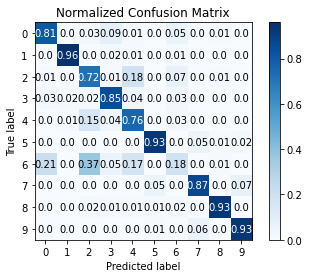

In [13]:
skplt.metrics.plot_confusion_matrix(train_set.targets,train_preds.argmax(dim=1), normalize=True)